In [1]:
import torch
import torch.utils.data
from torch import nn
from torch.nn import functional as F

from ignite.engine import Events, Engine
from ignite.metrics import Accuracy, Loss

import numpy as np
import sklearn.datasets

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
noise = 0.1
X_train, y_train = sklearn.datasets.make_moons(n_samples=1500, noise=noise)
X_test, y_test = sklearn.datasets.make_moons(n_samples=200, noise=noise)
ds_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), F.one_hot(torch.from_numpy(y_train)).float())
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=10, shuffle=True, drop_last=True)

In [3]:
dataiter = iter(dl_train)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)
print(images)
print(labels)
images = images +10
print(images)

torch.Size([10, 2])
torch.Size([10, 2])
tensor([[ 0.9204,  0.5725],
        [ 0.1283,  0.2354],
        [ 0.3785,  1.0331],
        [ 0.9499,  0.2376],
        [ 1.9896,  0.4155],
        [ 0.8938, -0.5976],
        [-0.8613,  0.6366],
        [ 0.1799, -0.1607],
        [ 0.1404,  0.0329],
        [ 0.2955,  0.7423]])
tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.]])
tensor([[10.9204, 10.5725],
        [10.1283, 10.2354],
        [10.3785, 11.0331],
        [10.9499, 10.2376],
        [11.9896, 10.4155],
        [10.8938,  9.4024],
        [ 9.1387, 10.6366],
        [10.1799,  9.8393],
        [10.1404, 10.0329],
        [10.2955, 10.7423]])


In [4]:
class Model_bilinear(nn.Module):
    def __init__(self, features, num_embeddings):
        super().__init__()
        
        self.gamma = 0.99
        self.sigma = 0.3
        
        embedding_size = 10
        
        self.fc1 = nn.Linear(2, features)
        self.fc2 = nn.Linear(features, features)
        self.fc3 = nn.Linear(features, features)
        
        self.W = nn.Parameter(torch.normal(torch.zeros(embedding_size, num_embeddings, features), 1))
        
        self.register_buffer('N', torch.ones(num_embeddings) * 20)
        self.register_buffer('m', torch.normal(torch.zeros(embedding_size, num_embeddings), 1))
        
        self.m = self.m * self.N.unsqueeze(0)

    def embed(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        # i is batch, m is embedding_size, n is num_embeddings (classes)
        x = torch.einsum('ij,mnj->imn', x, self.W)
        
        return x

    def bilinear(self, z):
        embeddings = self.m / self.N.unsqueeze(0)
        
        diff = z - embeddings.unsqueeze(0)            
        y_pred = (- diff**2).mean(1).div(2 * self.sigma**2).exp()
        
        return y_pred, embeddings

    def forward(self, x):
        z = self.embed(x)
        y_pred, embeddings = self.bilinear(z)
        
        return z, y_pred, embeddings

    def update_embeddings(self, x, y):
        z = self.embed(x)
        
        # normalizing value per class, assumes y is one_hot encoded
        self.N = torch.max(self.gamma * self.N + (1 - self.gamma) * y.sum(0), torch.ones_like(self.N))
        
        # compute sum of embeddings on class by class basis
        features_sum = torch.einsum('ijk,ik->jk', z, y)
        
        self.m = self.gamma * self.m + (1 - self.gamma) * features_sum
        
model = Model_bilinear(20, 2)
for name, param in model.named_buffers():
    print(name)
print("-----------")
for name, param in model.named_parameters():
    print(name)
print('--------')
state_dict = model.state_dict()
for name, value in state_dict.items():
    print(name)
print(model.N.shape)
print(model.m.shape)
print(model.W.shape)


print(model.N)
print('------------------------------------')
print(model.m)
print('------------------------------------')
print(model.W)

N
m
-----------
W
fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias
--------
W
N
m
fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias
torch.Size([2])
torch.Size([10, 2])
torch.Size([10, 2, 20])
tensor([20., 20.])
------------------------------------
tensor([[-18.9229, -19.6878],
        [-19.2994, -10.5744],
        [  8.3807,  -5.6351],
        [ 22.3169, -18.6757],
        [ 10.8986,   6.3476],
        [ 28.7822, -14.6420],
        [-15.3618,   3.3367],
        [ 11.0639,  -1.4276],
        [  5.8980,  11.6025],
        [-22.9213, -24.7638]])
------------------------------------
Parameter containing:
tensor([[[ 1.1190e-03,  1.8287e+00,  2.2930e+00,  1.1441e+00, -1.2798e+00,
           8.5662e-02,  8.6154e-01,  4.2406e-01,  9.7682e-01,  4.4976e-01,
           1.6507e-01,  1.5889e+00,  2.5847e+00, -1.2936e+00,  1.5687e+00,
          -3.2834e-01, -3.9348e-01, -2.7688e+00,  2.1872e-01,  2.4947e+00],
         [ 5.8141e-02,  1.1037e+00,  9.5329e-01, -1.5563e-01,  1.2636e

tensor([[[ 1.7349,  0.6932],
         [-0.1089,  1.2993],
         [ 0.5217,  0.2269],
         [ 0.5200,  0.7773],
         [-2.2434, -2.5837],
         [ 0.6295,  0.9507],
         [-2.6297,  0.0689],
         [-0.8166,  0.4849],
         [ 2.3317,  2.9701],
         [ 0.2387, -0.3661]]], grad_fn=<ViewBackward0>) tensor([[1.6373e-07, 2.4733e-07]], grad_fn=<ExpBackward0>) tensor([[-0.9461, -0.9844],
        [-0.9650, -0.5287],
        [ 0.4190, -0.2818],
        [ 1.1158, -0.9338],
        [ 0.5449,  0.3174],
        [ 1.4391, -0.7321],
        [-0.7681,  0.1668],
        [ 0.5532, -0.0714],
        [ 0.2949,  0.5801],
        [-1.1461, -1.2382]])


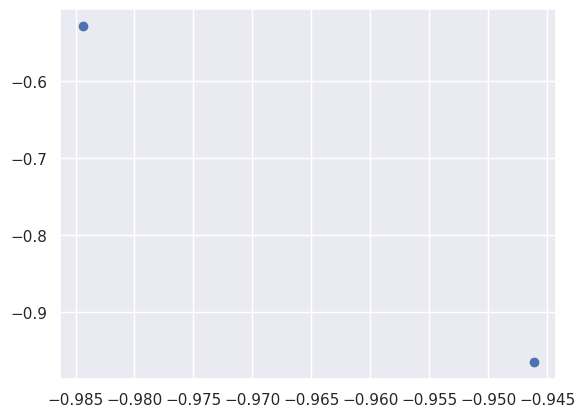

In [5]:
import matplotlib.pyplot as plt
emb = (model.m / model.N.unsqueeze(0)).numpy()
plt.scatter(emb[0], emb[1])

inp = torch.tensor([[-2.0, 0]])
x,y,z = model(inp)
print(x,y,z)

In [6]:
import copy
from torch.quantization import quantize_fx

quantise = True
if quantise:
    dataiter = iter(dl_train)
    images, labels = next(dataiter)
    images = images + 10
    m = copy.deepcopy(model)
    m.to("cpu")
    m.eval()
    qconfig_dict = {"": torch.quantization.get_default_qconfig("fbgemm")}
    model_prepared = quantize_fx.prepare_fx(m, qconfig_dict, images)

    with torch.inference_mode():
        for _ in range(10):
            images, labels = next(dataiter)
            images = images + 10
            model_prepared(images)
    model_quantized = quantize_fx.convert_fx(model_prepared)
    
for name, param in model_quantized.named_buffers():
    print(name)
print('--------')
for name, param in model_quantized.named_parameters():
    print(name)
print("-----------")
state_dict = model_quantized.state_dict()
for name, value in state_dict.items():
    print(name)
print(model_quantized._tensor_constant0.shape)
print(model_quantized._tensor_constant1.shape)
print(model_quantized.W.shape)

print(model_quantized._tensor_constant0)
print('------------------------------------')
print(model_quantized._tensor_constant1)
print('------------------------------------')
print(model_quantized.W)

fc1_input_scale_0
fc1_input_zero_point_0
_tensor_constant0
_scale_0
_zero_point_0
_tensor_constant1
--------
W
-----------
W
fc1_input_scale_0
fc1_input_zero_point_0
_tensor_constant0
_scale_0
_zero_point_0
_tensor_constant1
fc1.scale
fc1.zero_point
fc1._packed_params.dtype
fc1._packed_params._packed_params
fc2.scale
fc2.zero_point
fc2._packed_params.dtype
fc2._packed_params._packed_params
fc3.scale
fc3.zero_point
fc3._packed_params.dtype
fc3._packed_params._packed_params
torch.Size([1, 10, 2])
torch.Size([10, 2])
torch.Size([10, 2, 20])
tensor([[[-0.9461, -0.9844],
         [-0.9650, -0.5287],
         [ 0.4190, -0.2818],
         [ 1.1158, -0.9338],
         [ 0.5449,  0.3174],
         [ 1.4391, -0.7321],
         [-0.7681,  0.1668],
         [ 0.5532, -0.0714],
         [ 0.2949,  0.5801],
         [-1.1461, -1.2382]]])
------------------------------------
tensor([[-0.9461, -0.9844],
        [-0.9650, -0.5287],
        [ 0.4190, -0.2818],
        [ 1.1158, -0.9338],
        [ 0.544

/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/fx/prepare.py:1530: UserWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


tensor([[[ 2.0955e+00,  9.5419e-01],
         [-5.7717e-01,  1.9002e-01],
         [ 2.4282e-01, -6.3976e-02],
         [ 8.4287e-01,  4.0789e-01],
         [-1.8460e+00, -1.1067e+00],
         [ 4.3786e-01,  5.4780e-01],
         [-8.9031e-01,  8.0329e-04],
         [-1.3864e+00,  1.3366e-01],
         [ 9.5989e-01,  1.8526e+00],
         [-2.0281e-01,  4.5090e-02]]], grad_fn=<ViewBackward0>) tensor([[1.9663e-05, 7.2850e-04]]) tensor([[-0.9461, -0.9844],
        [-0.9650, -0.5287],
        [ 0.4190, -0.2818],
        [ 1.1158, -0.9338],
        [ 0.5449,  0.3174],
        [ 1.4391, -0.7321],
        [-0.7681,  0.1668],
        [ 0.5532, -0.0714],
        [ 0.2949,  0.5801],
        [-1.1461, -1.2382]])


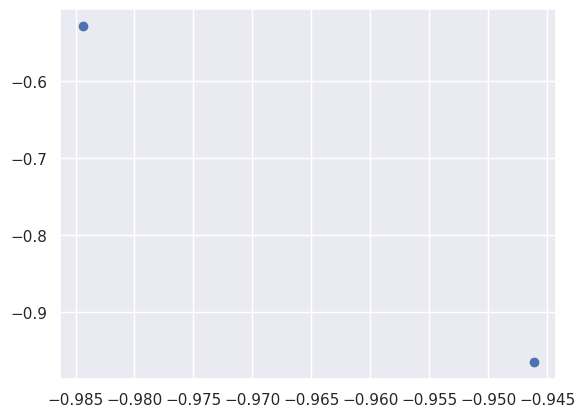

In [7]:
import matplotlib.pyplot as plt
emb = (model_quantized._tensor_constant1).numpy()
plt.scatter(emb[0], emb[1])


inpu = torch.tensor([[-2.0, 0]])
x,y,z = model_quantized(inpu)
print(x,y,z)

tensor([[[ 1.7349,  0.6932],
         [-0.1089,  1.2993],
         [ 0.5217,  0.2269],
         [ 0.5200,  0.7773],
         [-2.2434, -2.5837],
         [ 0.6295,  0.9507],
         [-2.6297,  0.0689],
         [-0.8166,  0.4849],
         [ 2.3317,  2.9701],
         [ 0.2387, -0.3661]]], grad_fn=<ViewBackward0>) tensor([[1.6373e-07, 2.4733e-07]], grad_fn=<ExpBackward0>) tensor([[-0.9461, -0.9844],
        [-0.9650, -0.5287],
        [ 0.4190, -0.2818],
        [ 1.1158, -0.9338],
        [ 0.5449,  0.3174],
        [ 1.4391, -0.7321],
        [-0.7681,  0.1668],
        [ 0.5532, -0.0714],
        [ 0.2949,  0.5801],
        [-1.1461, -1.2382]])


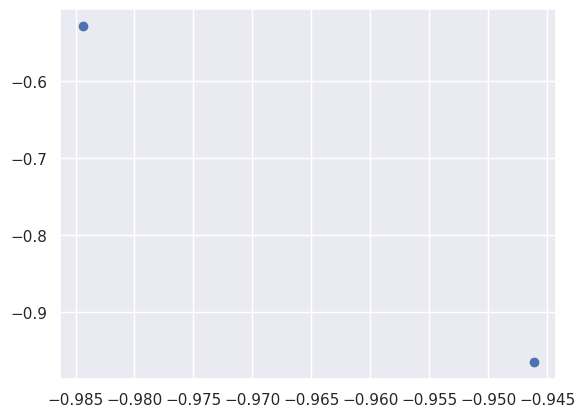

In [8]:
dataiter = iter(dl_train)
x, y = next(dataiter)
z, y_pred, embeddings = model(x)

emb = (model.m / model.N.unsqueeze(0)).detach().numpy()
plt.scatter(emb[0], emb[1])

inp = torch.tensor([[-2.0, 0]])
x,y,z = model(inp)
print(x,y,z)

tensor([[[ 2.0955e+00,  9.5419e-01],
         [-5.7717e-01,  1.9002e-01],
         [ 2.4282e-01, -6.3976e-02],
         [ 8.4287e-01,  4.0789e-01],
         [-1.8460e+00, -1.1067e+00],
         [ 4.3786e-01,  5.4780e-01],
         [-8.9031e-01,  8.0329e-04],
         [-1.3864e+00,  1.3366e-01],
         [ 9.5989e-01,  1.8526e+00],
         [-2.0281e-01,  4.5090e-02]]], grad_fn=<ViewBackward0>) tensor([[1.9663e-05, 7.2850e-04]]) tensor([[-0.9461, -0.9844],
        [-0.9650, -0.5287],
        [ 0.4190, -0.2818],
        [ 1.1158, -0.9338],
        [ 0.5449,  0.3174],
        [ 1.4391, -0.7321],
        [-0.7681,  0.1668],
        [ 0.5532, -0.0714],
        [ 0.2949,  0.5801],
        [-1.1461, -1.2382]])


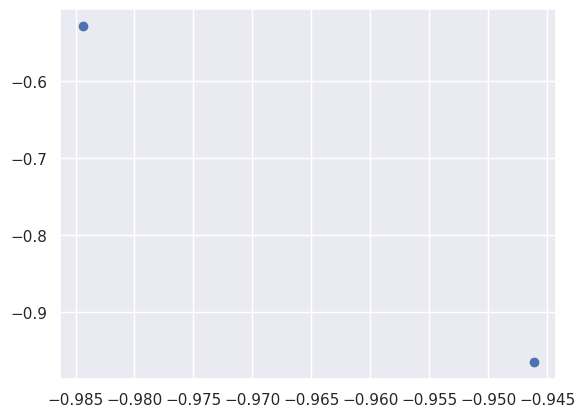

In [9]:
dataiter = iter(dl_train)
x, y = next(dataiter)
z, y_pred, embeddings = model_quantized(x)

emb = (model_quantized._tensor_constant1).numpy()
plt.scatter(emb[0], emb[1])
inpu = torch.tensor([[-2.0, 0]])
x,y,z = model_quantized(inpu)
print(x,y,z)

In [10]:
np.random.seed(0)
torch.manual_seed(0)

l_gradient_penalty = 1.0

# Moons
noise = 0.1
X_train, y_train = sklearn.datasets.make_moons(n_samples=1500, noise=noise)
X_test, y_test = sklearn.datasets.make_moons(n_samples=200, noise=noise)

num_classes = 2
batch_size = 64

model = Model_bilinear(20, num_classes)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)


def calc_gradient_penalty(x, y_pred):
    gradients = torch.autograd.grad(
            outputs=y_pred,
            inputs=x,
            grad_outputs=torch.ones_like(y_pred),
            create_graph=True,
        )[0]


    gradients = gradients.flatten(start_dim=1)
    
    # L2 norm
    grad_norm = gradients.norm(2, dim=1)

    # Two sided penalty
    gradient_penalty = ((grad_norm - 1) ** 2).mean()
    
    # One sided penalty - down
#     gradient_penalty = F.relu(grad_norm - 1).mean()

    return gradient_penalty


def output_transform_acc(output):
    y_pred, y, x, z = output
    
    y = torch.argmax(y, dim=1)
        
    return y_pred, y


def output_transform_bce(output):
    y_pred, y, x, z = output

    return y_pred, y


def output_transform_gp(output):
    y_pred, y, x, z = output

    return x, y_pred


def step(engine, batch):
    model.train()
    optimizer.zero_grad()
    
    x, y = batch
    x = x + 10
    x.requires_grad_(True)
    
    z, y_pred, embeddings = model(x)
    
    loss1 =  F.binary_cross_entropy(y_pred, y)
    loss2 = l_gradient_penalty * calc_gradient_penalty(x, y_pred)
    
    loss = loss1 + loss2
    
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        model.update_embeddings(x, y)
    
    return loss.item()


def eval_step(engine, batch):
    model.eval()

    x, y = batch
    x = x + 10

    x.requires_grad_(True)

    z, y_pred, embeddings = model(x)

    return y_pred, y, x, z
    

trainer = Engine(step)
evaluator = Engine(eval_step)

metric = Accuracy(output_transform=output_transform_acc)
metric.attach(evaluator, "accuracy")

metric = Loss(F.binary_cross_entropy, output_transform=output_transform_bce)
metric.attach(evaluator, "bce")

metric = Loss(calc_gradient_penalty, output_transform=output_transform_gp)
metric.attach(evaluator, "gp")


ds_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), F.one_hot(torch.from_numpy(y_train)).float())
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last=True)

ds_test = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), F.one_hot(torch.from_numpy(y_test)).float())
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=200, shuffle=False)

@trainer.on(Events.EPOCH_COMPLETED)
def log_results(trainer):
    evaluator.run(dl_test)
    metrics = evaluator.state.metrics

    print("Test Results - Epoch: {} Acc: {:.4f} BCE: {:.2f} GP {:.2f}"
          .format(trainer.state.epoch, metrics['accuracy'], metrics['bce'], metrics['gp']))

In [11]:
trainer.run(dl_train, max_epochs=30)

Test Results - Epoch: 1 Acc: 0.5000 BCE: 50.00 GP 1.00
Test Results - Epoch: 2 Acc: 0.5000 BCE: 50.00 GP 1.00
Test Results - Epoch: 3 Acc: 0.5000 BCE: 50.00 GP 1.00
Test Results - Epoch: 4 Acc: 0.5000 BCE: 50.00 GP 1.00
Test Results - Epoch: 5 Acc: 0.5000 BCE: 50.00 GP 1.00
Test Results - Epoch: 6 Acc: 0.5000 BCE: 50.00 GP 1.00
Test Results - Epoch: 7 Acc: 0.5000 BCE: 50.00 GP 1.00
Test Results - Epoch: 8 Acc: 0.5000 BCE: 50.00 GP 1.00
Test Results - Epoch: 9 Acc: 0.5000 BCE: 49.89 GP 1.00
Test Results - Epoch: 10 Acc: 0.5000 BCE: 50.00 GP 1.00
Test Results - Epoch: 11 Acc: 0.5000 BCE: 50.00 GP 1.00
Test Results - Epoch: 12 Acc: 0.5000 BCE: 50.00 GP 1.00
Test Results - Epoch: 13 Acc: 0.5000 BCE: 50.00 GP 1.00
Test Results - Epoch: 14 Acc: 0.5000 BCE: 50.00 GP 1.00
Test Results - Epoch: 15 Acc: 0.5000 BCE: 50.00 GP 1.00
Test Results - Epoch: 16 Acc: 0.5000 BCE: 50.00 GP 1.00
Test Results - Epoch: 17 Acc: 0.5000 BCE: 50.00 GP 1.00
Test Results - Epoch: 18 Acc: 0.5000 BCE: 50.00 GP 1.00
T

State:
	iteration: 690
	epoch: 30
	epoch_length: 23
	max_epochs: 30
	output: 51.0
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

tensor([[ 4.6384e+01,  6.1966e-02],
        [-2.7193e+02, -1.6030e+01],
        [ 1.1211e+02, -5.2548e+01],
        [ 1.7316e+01,  4.0571e+00],
        [-5.1378e+01,  1.1942e+02],
        [-1.4505e+02, -7.6665e+01],
        [-2.5127e+02,  2.0328e+01],
        [ 1.3384e+01,  4.8864e+00],
        [-2.2684e+02, -1.8451e+02],
        [ 3.0414e+02, -6.1414e+01]])
tensor([[  33.0133,    9.2978],
        [-135.4771,  -11.2149],
        [  52.3947,  -29.2802],
        [   6.4806,  -12.2253],
        [ -27.1855,   59.7309],
        [ -68.4448,  -37.1466],
        [-116.0542,   13.7488],
        [  -6.8651,    9.2739],
        [ -92.1706,  -99.9666],
        [ 148.0281,  -28.6342]])


/tmp/ipykernel_2044/2057982734.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = y_vis.astype(np.bool)


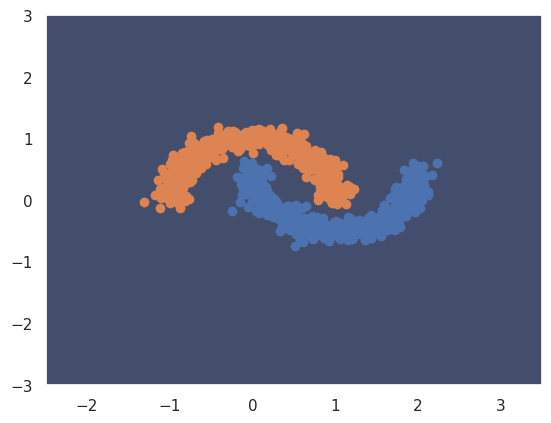

In [12]:
domain = 3
x_lin = np.linspace(-domain+0.5, domain+0.5, 100)
y_lin = np.linspace(-domain, domain, 100)

xx, yy = np.meshgrid(x_lin, y_lin)

X_grid = np.column_stack([xx.flatten(), yy.flatten()])

X_vis, y_vis = sklearn.datasets.make_moons(n_samples=1000, noise=noise)
mask = y_vis.astype(np.bool)


with torch.no_grad():
    z, output, embeddings = model(torch.from_numpy(X_grid).float())
    print(embeddings)
    print(z[0])
    confidence = output.max(1)[0].numpy()


z = confidence.reshape(xx.shape)

plt.figure()
plt.contourf(x_lin, y_lin, z, cmap='cividis')

plt.scatter(X_vis[mask,0], X_vis[mask,1])
plt.scatter(X_vis[~mask,0], X_vis[~mask,1])

In [13]:
print(X_grid.shape)

print(str(model))

(10000, 2)
Model_bilinear(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
)


In [14]:
# output = model(torch.from_numpy(np.array([0,0])).float())[1]

In [15]:
import copy
from torch.quantization import quantize_fx

quantise = True
if quantise:
    dataiter = iter(dl_train)
    images, labels = next(dataiter)
    images = images + 10

    m = copy.deepcopy(model)
    m.to("cpu")
    m.eval()
    qconfig_dict = {"": torch.quantization.get_default_qconfig("fbgemm")}
    model_prepared = quantize_fx.prepare_fx(m, qconfig_dict, images)

    with torch.inference_mode():
        for _ in range(10):
            images, labels = next(dataiter)
            images = images + 10
            model_prepared(images)
    model_quantized = quantize_fx.convert_fx(model_prepared)
    


In [16]:
print(model_quantized)

GraphModule(
  (fc1): QuantizedLinearReLU(in_features=2, out_features=20, scale=0.13011117279529572, zero_point=0, qscheme=torch.per_channel_affine)
  (fc2): QuantizedLinearReLU(in_features=20, out_features=20, scale=0.4100205600261688, zero_point=0, qscheme=torch.per_channel_affine)
  (fc3): QuantizedLinear(in_features=20, out_features=20, scale=0.8096545934677124, zero_point=50, qscheme=torch.per_channel_affine)
)



def forward(self, x):
    fc1_input_scale_0 = self.fc1_input_scale_0
    fc1_input_zero_point_0 = self.fc1_input_zero_point_0
    quantize_per_tensor = torch.quantize_per_tensor(x, fc1_input_scale_0, fc1_input_zero_point_0, torch.quint8);  x = fc1_input_scale_0 = fc1_input_zero_point_0 = None
    fc1 = self.fc1(quantize_per_tensor);  quantize_per_tensor = None
    fc2 = self.fc2(fc1);  fc1 = None
    fc3 = self.fc3(fc2);  fc2 = None
    dequantize_3 = fc3.dequantize();  fc3 = None
    w = self.W
    einsum = torch.functional.einsum('ij,mnj->imn', dequantize_3, w);  dequa

In [17]:
model_quantized.print_readable()

class GraphModule(torch.nn.Module):
    def forward(self, x):
        
        # No stacktrace found for following nodes 
        fc1_input_scale_0 = self.fc1_input_scale_0
        fc1_input_zero_point_0 = self.fc1_input_zero_point_0
        quantize_per_tensor = torch.quantize_per_tensor(x, fc1_input_scale_0, fc1_input_zero_point_0, torch.quint8);  x = fc1_input_scale_0 = fc1_input_zero_point_0 = None
        
        # File: /opt/conda/lib/python3.10/site-packages/torch/ao/quantization/fx/tracer.py:103, code: return super().call_module(m, forward, args, kwargs)
        fc1 = self.fc1(quantize_per_tensor);  quantize_per_tensor = None
        
        # File: /opt/conda/lib/python3.10/site-packages/torch/ao/quantization/fx/tracer.py:103, code: return super().call_module(m, forward, args, kwargs)
        fc2 = self.fc2(fc1);  fc1 = None
        
        # File: /opt/conda/lib/python3.10/site-packages/torch/ao/quantization/fx/tracer.py:103, code: return super().call_module(m, forward, ar

tensor([[ 4.6384e+01,  6.1966e-02],
        [-2.7193e+02, -1.6030e+01],
        [ 1.1211e+02, -5.2548e+01],
        [ 1.7316e+01,  4.0571e+00],
        [-5.1378e+01,  1.1942e+02],
        [-1.4505e+02, -7.6665e+01],
        [-2.5127e+02,  2.0328e+01],
        [ 1.3384e+01,  4.8864e+00],
        [-2.2684e+02, -1.8451e+02],
        [ 3.0414e+02, -6.1414e+01]])
tensor([[  4.4886,   1.9410],
        [-12.9904,  -1.1852],
        [  5.8172,  -1.0439],
        [  1.5656,  -3.4798],
        [ -2.4878,   5.7246],
        [ -4.2454,  -3.7673],
        [ -9.1813,   1.2678],
        [  0.3032,   1.4203],
        [ -6.6385, -10.5519],
        [ 13.5649,  -1.5685]])


/tmp/ipykernel_2044/2489577463.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = y_vis.astype(np.bool)


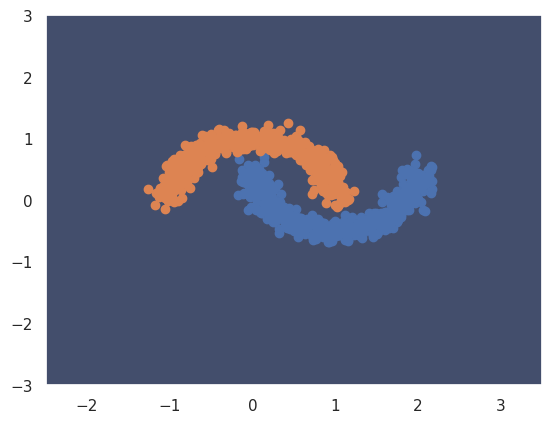

In [18]:
domain = 3
x_lin = np.linspace(-domain+0.5, domain+0.5, 100)
y_lin = np.linspace(-domain, domain, 100)

xx, yy = np.meshgrid(x_lin, y_lin)

X_grid = np.column_stack([xx.flatten(), yy.flatten()])

X_vis, y_vis = sklearn.datasets.make_moons(n_samples=1000, noise=noise)
mask = y_vis.astype(np.bool)

with torch.no_grad():
    z, output, embeddings = model_quantized(torch.from_numpy(X_grid).float())
    print(embeddings)
    print(z[0])
    confidence = output.max(1)[0].numpy()


z = confidence.reshape(xx.shape)

plt.figure()
plt.contourf(x_lin, y_lin, z, cmap='cividis')

plt.scatter(X_vis[mask,0], X_vis[mask,1])
plt.scatter(X_vis[~mask,0], X_vis[~mask,1])

- input t